In [4]:
!pip install timm


In [20]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [8]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = 'drive/MyDrive/plant_disease_detection/dataset'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'valid']}


In [9]:
# Recreate the model architecture
model = timm.create_model('tf_efficientnetv2_s', pretrained=False, num_classes=len(image_datasets['valid'].classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Load the saved model weights
model.load_state_dict(torch.load('drive/MyDrive/plant_disease_detection/models/efficientnet_v2_S_nightshade_plant_disease_detection_model.pth'))
# Set the model to evaluation mode
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [17]:
# Define data transformations for the new image
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

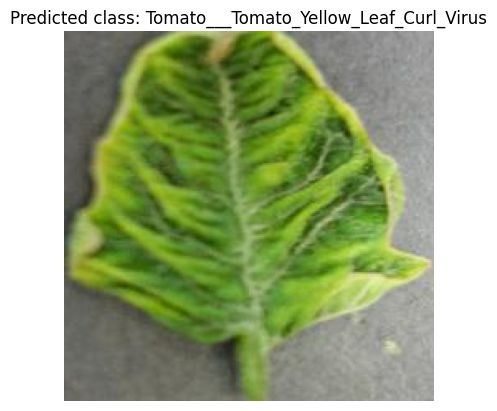

In [22]:
# Load the image
image_path = 'drive/MyDrive/plant_disease_detection/dataset/test/TomatoYellowCurlVirus6.JPG'
image = Image.open(image_path)

# Apply the transformations
image_transformed = data_transforms(image)

# Add a batch dimension (batch size of 1)
image_transformed = image_transformed.unsqueeze(0)

# Move the image to the appropriate device
image_transformed = image_transformed.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(image_transformed)
    _, preds = torch.max(outputs, 1)

# Get the class names
class_names = image_datasets['valid'].classes

# Print the predicted class
predicted_class = class_names[preds[0]]


# Convert the image tensor back to a CPU tensor and then to a NumPy array
image_transformed_cpu = image_transformed.squeeze().cpu().numpy()

# Undo the normalization applied during the transformation
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_transformed_cpu = std * image_transformed_cpu.transpose((1, 2, 0)) + mean
image_transformed_cpu = np.clip(image_transformed_cpu, 0, 1)

# Display the image with the predicted class
plt.imshow(image_transformed_cpu)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')  # Hide axes
plt.show()